# 패턴인식 설계 과제
# <한국어 문장 긍정,부정문 이진분류>
## 단국대학교 컴퓨터공학과 
## 32184074 정민준
jmj284@gmail.com<br> 
010-9391-0801

# <모델 사용 및 평가 코드>

## <학습 및 테스트 환경> <br>
본 프로그램은 'Google Colab' 환경에서 작성 되었습니다.<br>
플랫폼: 'Goolge Colab'<br> 
GPU: Tesla T4<br> 
GPU API: CUDA<br>
<br>사용한 언어 및 라이브러리는 아래와 같습니다.
<br>

## <언어> <br>

###1. python3
Version: 3.7.14 (default, Sep  8 2022, 00:06:44)<br>
GCC 7.5.0<br>

## <라이브러리> <br>

###1. transformers
Version: 4.23.1<br> 
License: Apache<br>

###2. torch
Version: 1.12.1+cu113<br>
License: BSD-3<br>

###3. tensorflow)<br>
Version: 2.9.2<br>
License: Apache 2.0<br>

###4. keras
Version: 2.9.0<br>
License: Apache 2.0<br>

###5. scikit-learn
Version: 1.0.2<br>
License: new BSD<br>

###6. pandas
Version: 1.3.5<br> 
License: BSD-3-Clause<br>

###7. numpy
Version: 1.21.6<br>
License: BSD<br>

###8. matplotlib
Version: 3.2.2<br> 
License: PSF<br>

## <사전학습모델> 
KoBERT-Transfomers<br>
License: Apache 2.0

## <참고자료>

1. https://mccormickml.com/2019/07/22/BERT-fine-tuning/

2. https://github.com/monologg/KoBERT-Transformers/blob/master/kobert_transformers/tokenization_kobert.py

3. https://velog.io/@seolini43/일상연애-주제의-한국어-대화-BERT로-이진-분류-모델-만들기파이썬Colab-코드

# 사용법

1. 모델 호출 및 설정은 반드시 먼저 실행합니다.<br>(모델 사용에 필요한 모델 및 라이브러리 호출)

2. '문장 입력' 기능은 사용자가 입력한 문장을 긍정 혹은 부정으로 출력해줍니다.

3. '파일 처리' 기능은 규격에 맞는 csv 데이터를 분류 및 처리해서 result.csv로 반환합니다.<br> (데이터는 Sentences(String) 으로 이루어져야함)

4. '모델 평가' 기능은 규격에 맞는 csv 데이터로 모델을 평가후 ACC, AUC Score, 처리시간, Roc Curve를 반환합니다.<br>
(데이터는 Sentences(String), Emotions(0,1) 으로 이루어져야함)


# 모델 호출 및 설정

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip3 install kobert-transformers

In [ ]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
from transformers import BertTokenizer
import csv
import numpy as np
import random
import time
import datetime

In [ ]:
# GPU 확인하기
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


In [ ]:
#코랩 환경에서 gpu 사용가능 여부를 판별 및 device 할당 위해서 사용

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
#코랩 환경에서 구글 드라이브 사용시 마운트 필요, 불필요 혹은 오류 발생시 주석 처리 후 실행
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
from kobert_transformers import get_tokenizer
tokenizer = get_tokenizer()

model = BertForSequenceClassification.from_pretrained('/drive/MyDrive/P_OR_N_MODEL')
model.cuda()

# 문장 입력

In [ ]:
#시그모이드
def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


test_ans = [] #모델의 결과 저장
test_prob = [] #가능성 저장

#시작 시간 설정
t0 = time.time()

#테스트셋 데이터 전처리
def convert_input_data(sentences):
    sentences = ["[CLS] " + str(sentences) + " [SEP]"]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 150

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

#모델 사용
def Emotion_Binary_Classification(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    
    #시그모이드 함수, 확률 판단
    pred = sigmoid(logits)
    
    #결과 판단
    result = np.argmax(pred)

    return [result,pred]


In [ ]:
s = input("감정을 분류할 문장을 입력하세요: ")
a,p = Emotion_Binary_Classification(s)

if a == 0:
  print('"',s,'"',"는 부정문입니다.")
else:
  print('"',s,'"',"는 긍정문입니다.")  

감정을 분류할 문장을 입력하세요: 너 진짜 짜증나
" 너 진짜 짜증나 " 는 부정문입니다.


# 파일 처리(csv)

In [12]:
#시그모이드
def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


test_ans = [] #모델의 결과 저장
test_prob = [] #가능성 저장

#시작 시간 설정
t0 = time.time()

#테스트셋 데이터 전처리
def convert_input_data(sentences):
    sentences = ["[CLS] " + str(sentences) + " [SEP]"]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 150

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

#모델 사용
def Emotion_Binary_Classification(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    
    #시그모이드 함수, 확률 판단
    pred = sigmoid(logits)
    
    #결과 판단
    result = np.argmax(pred)

    return [result,pred]

In [14]:
import csv

df = pd.DataFrame([],columns=['Sentences','Emotions'])

path = input("분류할 csv 파일의 경로를 입력하세요:")
print("ex: /drive/MyDrive/kor_bin_data/test_data.csv")
csv_test = pd.read_csv(path,encoding="utf-8")

for i in range(len(csv_test)):
  r,p = Emotion_Binary_Classification(csv_test['Sentences'][i])
  df.loc[i] = [csv_test['Sentences'][i],r]

df.to_csv('./result.csv')
print("분류 및 저장 완료!(./result.csv)")

분류할 csv 파일의 경로를 입력하세요:/drive/MyDrive/kor_bin_data/test_data.csv


# 모델 평가

In [15]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
#시그모이드
def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


#테스트셋 데이터 전처리
def convert_input_data(sentences):
    sentences = ["[CLS] " + str(sentences) + " [SEP]"]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 150

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

#모델 사용
def Determining_Acute_Ischemic_Stroke(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    
    #시그모이드 함수, 확률 판단
    pred = sigmoid(logits)
    
    #결과 판단
    result = np.argmax(pred)

    return [result,pred]


분류에 소요된 시간: 0:00:00


In [24]:
path = input("모델 평가에 사용할 csv 파일의 경로를 입력하세요:")
print("ex: /drive/MyDrive/kor_bin_data/test_data.csv")
csv_eval = pd.read_csv(path,encoding="utf-8")

#이진 분류 결과(0 or 1)이 담길 정답 리스트
test_ans = []

#이진 분류 결과의 확률([0~1,0~1])이 담길 정답 리스트
test_prob = []

#입력 데이터
d = csv_eval.Sentences
d.reset_index(drop=True, inplace=True)

#실제 정답 
labels = csv_eval.Emotions

#시작 시간 설정
t0 = time.time()

for i in range(len(d)):
  #함수 호출, 이진분류 결과는 a, 확률은 p
  a,p = Determining_Acute_Ischemic_Stroke(d[i])
  test_ans.append(a) #결과 값은 test_ans에 저장
  test_prob.append(p) #확률 값은 test_prob에 저장

#소요된 시간 저장
pt = format(format_time(time.time() - t0))

모델 평가에 사용할 csv 파일의 경로를 입력하세요:/drive/MyDrive/kor_bin_data/test_data.csv
ex: /drive/MyDrive/kor_bin_data/test_data.csv
분류에 소요된 시간: 0:02:54


총 테스트 데이터의 수: 9113
분류에 소요된 시간: 0:02:54
Accuracy : 0.898167
AUC Score: 0.955392



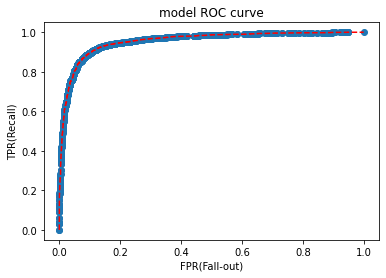

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#probabilty중 정답이 1일 확률이 담길 리스트 
t_prob =[]

print('총 테스트 데이터의 수:',len(test_prob))
print("분류에 소요된 시간:",pt)


#probabilty중 정답이 1일 확률(model.predict_proba() 와 동일)
for i in test_prob:
  t_prob.append(i[0][1])

cnt = 0
for i in range(len(test_ans)):
  if test_ans[i] == labels[i]:
      cnt += 1

print('Accuracy :',round(cnt/len(test_ans),6))      
# roc_curve 그래프 그리기
fpr, tpr, thresholds = roc_curve(labels, t_prob)

roc = pd.DataFrame({'FPR(Fall-out)': fpr, 'TPRate(Recall)': tpr, 'Threshold': thresholds})

plt.scatter(fpr, tpr)
plt.title('model ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.plot(fpr, tpr, 'r--')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 최적의 threshold
#print('idx:',optimal_idx, 'threshold:', optimal_threshold)

# AUC 면적 구하기
auc_score = roc_auc_score(labels, t_prob)
print('AUC Score:',round(auc_score,6))
print()